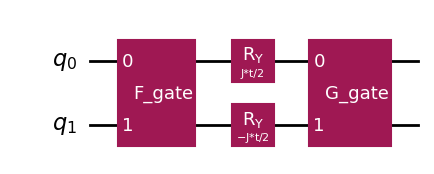

In [105]:
from qiskit.circuit import QuantumCircuit, Parameter, QuantumRegister, ClassicalRegister

# Hopping Term
## Creating the f_gates:
f_circ =  QuantumCircuit(2)
f_circ.h([0,1])
f_circ.s([0,1])
f_circ.h([0,1])
f_circ.cx(0,1)
f_circ.h(1)
f_circ.z(1)
f_circ.s([0,1])
f_circ.h([0,1])

f_gate = f_circ.to_gate(label = 'F_gate')

## Creating the g_gates:
g_circ =  QuantumCircuit(2)
g_circ.h([0,1])
g_circ.z(0)
g_circ.s(0)
g_circ.s(1)
g_circ.h(1)
g_circ.cx(0,1)
g_circ.h([0,1])
g_circ.z([0,1])
g_circ.s([0,1])
g_circ.h([0,1])

g_gate = g_circ.to_gate(label = 'G_gate')

## Creating the hopping gate
t = Parameter(fr't')
J = Parameter(f'J')

# cycles = 3

# sysqubits = 1
# timeresamples = 10

# targ = Parameter(r'$E_\odot$')
# t = [Parameter(fr'$t_{i}$') for i in range(cycles)]


hop_circ = QuantumCircuit(2)
hop_circ.append(f_gate, [0,1])
hop_circ.ry((J*t)/2, 0)
hop_circ.ry((-1*J*t)/2, 1)
hop_circ.append(g_gate, [0,1])

A_gate = hop_circ.to_gate(label = "A_gate") # Hopping gate between nearest neighbors
hop_circ.draw('mpl')

In [107]:
# Conservation Test
from qiskit.quantum_info import Statevector

circuit = QuantumCircuit(2)
circuit.x(0)
circuit.x(1)
circuit.append(A_gate, range(2))
parameters = {t:0.1, J : -1}
circuit1 = circuit.assign_parameters(parameters, inplace=False)

# Get the statevector
state = Statevector.from_instruction(circuit1)

# Display the statevector
print("Statevector:", state)


Statevector: Statevector([0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
            dims=(2, 2))


In [108]:
# Creating onsite operator
U = Parameter(f'U')

onsite_circ = QuantumCircuit(2)
onsite_circ.cx(0,1)
onsite_circ.ry(2*U*t, 1)
onsite_circ.cx(0,1)

onsite_circ.draw('mpl')

B_gate = onsite_circ.to_gate(label = f'B_gate')

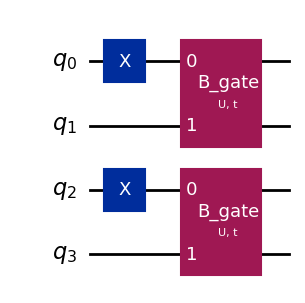

In [109]:
# Hard-Coding a 1x4 Hubbard Model

num_sites = 2
num_qubits = num_sites*2

hubbard = QuantumCircuit(num_qubits)
for i in range(num_qubits):
    if i%2 == 1:
        continue
    else:
        hubbard.x(i)

even_spin_up_indices = [i * 2 for i in range(num_sites) if i % 2 == 0]
odd_spin_up_indices = [i * 2 for i in range(num_sites) if i % 2 == 1]

even_spin_down_indices = [i * 2 + 1 for i in range(num_sites) if i % 2 == 0]
odd_spin_down_indices = [i * 2 + 1 for i in range(num_sites) if i % 2 == 1]


for j in range(len(even_spin_up_indices) - 1):
    hubbard.append(A_gate, [even_spin_up_indices[j], even_spin_up_indices[j + 1]])
    hubbard.append(A_gate, [odd_spin_up_indices[j], odd_spin_up_indices[j + 1]])
    hubbard.append(A_gate, [even_spin_down_indices[j], even_spin_down_indices[j + 1]])
    hubbard.append(A_gate, [odd_spin_down_indices[j], odd_spin_down_indices[j + 1]])

for site in range(num_sites):
    spin_up_qubit = site * 2
    spin_down_qubit = site * 2 + 1
    hubbard.append(B_gate, [spin_up_qubit, spin_down_qubit])

hubbard.draw('mpl')

In [111]:
# Define the number of sites and qubits
def hubbard_model(num_sites_input):
    num_sites = num_sites_input  # This can be any integer >= 2
    num_qubits = num_sites * 2

    # Initialize the Hubbard circuit
    hubbard = QuantumCircuit(num_qubits)
    
    # Create indices for even and odd spin-up and spin-down qubits
    even_spin_up_indices = [i * 2 for i in range(num_sites) if i % 2 == 0]
    odd_spin_up_indices = [i * 2 for i in range(num_sites) if i % 2 == 1]

    even_spin_down_indices = [i * 2 + 1 for i in range(num_sites) if i % 2 == 0]
    odd_spin_down_indices = [i * 2 + 1 for i in range(num_sites) if i % 2 == 1]

    # Apply A_gate for hopping terms on the identified pairs of qubits
    # Ensure that the loop does not run out of bounds for odd-length lists
    for j in range(len(even_spin_up_indices) - 1):
        hubbard.append(A_gate, [even_spin_up_indices[j], even_spin_up_indices[j + 1]])
        
    for j in range(len(odd_spin_up_indices) - 1):
        hubbard.append(A_gate, [odd_spin_up_indices[j], odd_spin_up_indices[j + 1]])

    for j in range(len(even_spin_down_indices) - 1):
        hubbard.append(A_gate, [even_spin_down_indices[j], even_spin_down_indices[j + 1]])

    for j in range(len(odd_spin_down_indices) - 1):
        hubbard.append(A_gate, [odd_spin_down_indices[j], odd_spin_down_indices[j + 1]])


    # Apply B_gate for on-site interactions on each site
    for site in range(num_sites):
        spin_up_qubit = site * 2
        spin_down_qubit = site * 2 + 1
        hubbard.append(B_gate, [spin_up_qubit, spin_down_qubit])

    # return hubbard.to_gate(label = 'TrotterStep')
    return hubbard


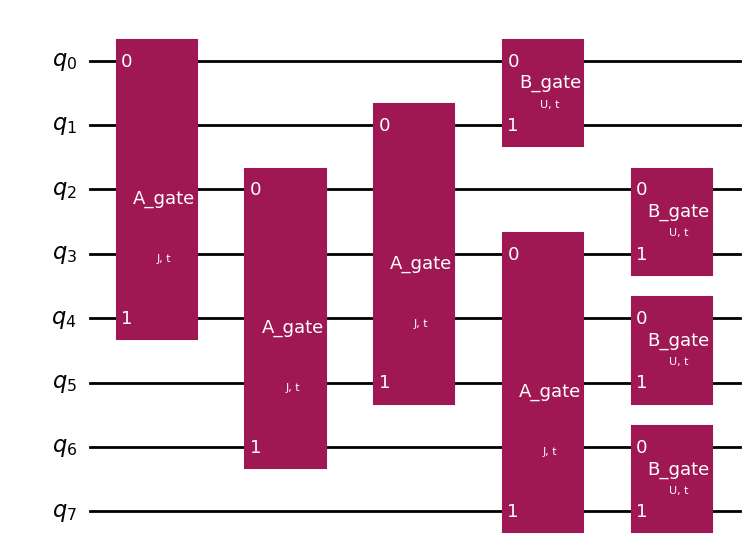

In [112]:
# num_sites = 2
# num_qubits = num_sites*2
# circuit = QuantumCircuit(num_qubits)
# time_evolution = hubbard_model(num_sites)


# circuit.draw('mpl')

circuit = hubbard_model(4)
circuit.draw('mpl')

In [104]:
# Trotter evolution with constant t, variable delta_t
def trotter_evolution_1(J_input, U_input, t_input, r, num_qubits):
    delta_t = t_input/r
    trotter_circuit = QuantumCircuit(num_qubits)
    for _ in range(r):
       trotter_circuit.append(time_evolution, range(num_qubits))
       parameters = {t:delta_t, J:J_input, U:U_input}
       circuit3 = trotter_circuit.assign_parameters(parameters, inplace =False)
    
    circuit_gate = circuit3.to_gate(label = rf"Trotter_{r}_steps")
    return circuit_gate

# Trotter evolution with constant delta_t, variable t depending on the number of rodeo steps
def trotter_evolution(J_input, U_input, delta_t, r, num_qubits):
    trotter_circuit = QuantumCircuit(num_qubits)
    for _ in range(r):
       trotter_circuit.append(time_evolution, range(num_qubits))
       parameters = {t:delta_t, J:J_input, U:U_input}
       circuit3 = trotter_circuit.assign_parameters(parameters, inplace =False)

    circuit_gate = circuit3.to_gate(label = rf"Trotter_{r}_steps")
    return circuit_gate

circ = QuantumCircuit(num_qubits)
trotter_gate  = trotter_evolution_1(1,1,1,4,num_qubits)
circ.append(trotter_gate, range(num_qubits))
circ.draw('mpl')
       

CircuitError: 'Cannot bind parameters (J) not present in the circuit.'

In [94]:
# Creating the Circuit to test Electron Conservation
num_sites = 4
num_qubits = num_sites * 2
classical = ClassicalRegister(num_qubits, 'c')
sys = QuantumRegister(num_qubits, 's')
circuit = QuantumCircuit(classical, sys)
trotter_gate  = trotter_evolution(1,1,0.1,4,num_qubits)
circuit.append(trotter_gate, range(num_qubits))

for i in range(num_qubits):
    circuit.measure(sys[i], classical[i])

circuit.draw('mpl')



CircuitError: 'The amount of qubit(8)/clbit(0) arguments does not match the gate expectation (4).'

In [95]:
from qiskit.circuit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit.primitives import StatevectorSampler
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram

# Define number of sites, qubits, and initialize the quantum circuit
classical = ClassicalRegister(num_qubits, 'c')
sys = QuantumRegister(num_qubits, 's')
circuit = QuantumCircuit(sys, classical)

# Define and append the Trotter gate with fixed parameters
trotter_gate = trotter_evolution_1(1, 1, 1, 20, num_qubits)
circuit.x(0)
circuit.x(4)
circuit.append(trotter_gate, range(num_qubits))


# Add measurement for each qubit
for i in range(num_qubits):
    circuit.measure(sys[i], classical[i])

# Run the StatevectorSampler without parameter variation
sampler = StatevectorSampler()
job = sampler.run([circuit], shots=256)
result = job.result()[0]

# Retrieve and print bitstring outcomes
bitstrings = result.data.c.get_bitstrings(0)  # Only one job, so index is 0
print("Bitstrings:", bitstrings)

# Get and plot counts as a histogram for analysis
counts = result.data.c.get_counts(0)
plot_histogram(counts)
plt.show()


CircuitError: 'The amount of qubit(8)/clbit(0) arguments does not match the gate expectation (4).'

In [96]:
from qiskit.circuit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit.primitives import StatevectorSampler
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram

# Define number of sites and qubits, initialize the quantum circuit
classical = ClassicalRegister(num_qubits, 'c')
sys = QuantumRegister(num_qubits, 's')
circuit = QuantumCircuit(sys)

# Define and append the Trotter gate with fixed parameters
trotter_gate = trotter_evolution(1, 1, 0.1, 20, num_qubits)
circuit.append(trotter_gate, range(num_qubits))

# Add measurement for each qubit
# for i in range(num_qubits):
#     circuit.measure(sys[i], classical[i])

# Get the statevector
state = Statevector.from_instruction(circuit)

# Display the statevector
print("Statevector:", state)

# Run the StatevectorSampler
sampler = StatevectorSampler()
job = sampler.run([circuit], shots=256)
result = job.result()[0]

# Check electron conservation by counting '1's in each bitstring
bitstrings = result.data.c.get_bitstrings(0)
initial_electron_count = sum(1 for i in range(num_qubits) if circuit.data[i][0].name == 'x')  # Count initial '1's

# Verify conservation
for i, bitstring in enumerate(bitstrings[:10]):  # Display first 10 bitstrings as an example
    electron_count = bitstring.count('1')
    print(f"Bitstring {i+1}: {bitstring} - Electron Count: {electron_count}")
    assert electron_count == initial_electron_count, "Electron conservation violated!"

# Get and plot counts as a histogram for visual analysis
counts = result.data.c.get_counts(0)
plot_histogram(counts)
plt.show()


CircuitError: 'The amount of qubit(8)/clbit(0) arguments does not match the gate expectation (4).'